# Faulty zero filter

This notebook shows the "FZ_filter" to detect faulty zeros in rainfall time series based on data from neighboring sensors.

The original R code stems from https://github.com/LottedeVos/PWSQC/. The current code is a variation of [this](https://github.com/NiekvanAndel/QC_radar/blob/main/script_1_0.py) Python implementation of the original R code.

The idea of the filter is to evaluate rainfall data of a sensors (in our case here a PWS) in comparison to a reference, which in case of a PWS network stems from neighboring sensors, and flag period where the reference has non-zero rainfall but the data in question is showing zeros for a a minimum number of consecutive time steps.

Below, we use open PWS dataset from Amsterdam, called the "AMS PWS" dataset.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import poligrain as plg
import xarray as xr

import pypwsqc

/var/folders/8f/z1lq69v144zb2p1_l1twh7kh0006md/T/ipykernel_42447/4139509896.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Get AMS PWS data

We use this NetCDF which was prepared for the OPENSENSE training school.

(this will be updated to use an example dataset of `pypwsqc` soon)

In [2]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.7M  100 10.7M    0     0  3897k      0  0:00:02  0:00:02 --:--:-- 6885k   0  4330k      0  0:00:02  0:00:02 --:--:-- 6745k


In [3]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)

ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

## Cut data to short period and look at rainfall accumulations

In [4]:
# ds_pws = ds_pws.sel(time=slice('2017-09-12 23:30:00', '2017-09-13 04:00'))
ds_pws = ds_pws.sel(time=slice("2017-09-12 18:00:00", "2017-09-13 16:00"))

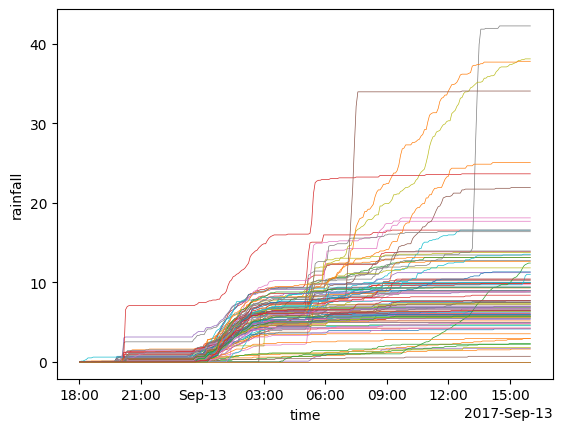

In [5]:
ds_pws.rainfall.cumsum(dim="time").plot.line(x="time", add_legend=False, linewidth=0.5);

## Select one PWS and a list of neighboring PWS

Here we use [`poligrain`](https://github.com/OpenSenseAction/poligrain) to first project the lon-lat coordinates to UTM 32N and then calculate the distances between the PWS in meters.

In [6]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.lon, y=ds_pws.lat, target_projection="EPSG:25832"
)

In [7]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)
distance_matrix

<xarray.DataArray (id: 134, id_neighbor: 134)>
array([[    0.        ,   518.79828487,   531.99603941, ...,
        28532.23134009, 25291.03668667, 25994.5064412 ],
       [  518.79828487,     0.        ,   728.38027968, ...,
        28493.8273213 , 24995.94592241, 25633.14869253],
       [  531.99603941,   728.38027968,     0.        , ...,
        28000.75903421, 24846.06853717, 25603.62271956],
       ...,
       [28532.23134009, 28493.8273213 , 28000.75903421, ...,
            0.        , 14448.29575676, 18710.76846276],
       [25291.03668667, 24995.94592241, 24846.06853717, ...,
        14448.29575676,     0.        ,  4264.61589559],
       [25994.5064412 , 25633.14869253, 25603.62271956, ...,
        18710.76846276,  4264.61589559,     0.        ]])
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'

From the distance matrix (which is an `xarray.Dataset` with the `id`s of our PWS dataset) we can easily get the station IDs within in certain maximum allowed distance.

In [8]:
pws_id = "ams2"

max_distance = 5e3  # this is in meters

neighbor_ids = distance_matrix.id.data[distance_matrix.sel(id=pws_id) < max_distance]
neighbor_ids

array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8',
       'ams9', 'ams12'], dtype='<U6')

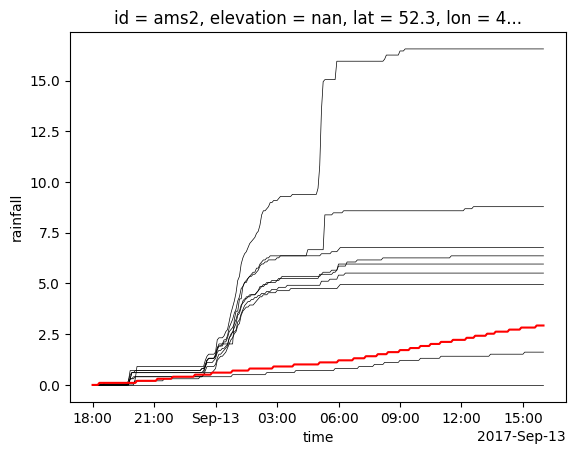

In [9]:
ds_pws.sel(id=neighbor_ids).rainfall.cumsum(dim="time").plot.line(
    x="time", add_legend=False, linewidth=0.5, color="k"
)

ds_pws.sel(id=pws_id).rainfall.cumsum().plot(color="r");

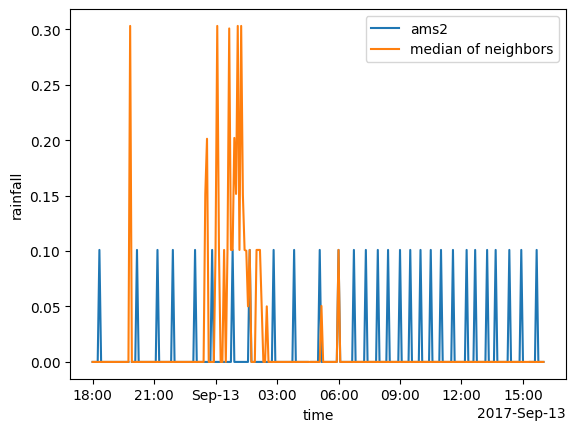

In [10]:
ds_pws.sel(id=pws_id).rainfall.plot(label="ams2")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")

plt.legend();

## Apply the faulty zero filter

In [11]:
fz_flag = pypwsqc.flagging.fz_filter(
    pws_data=ds_pws.sel(id=pws_id).rainfall,
    reference=ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id"),
    nint=3,
)

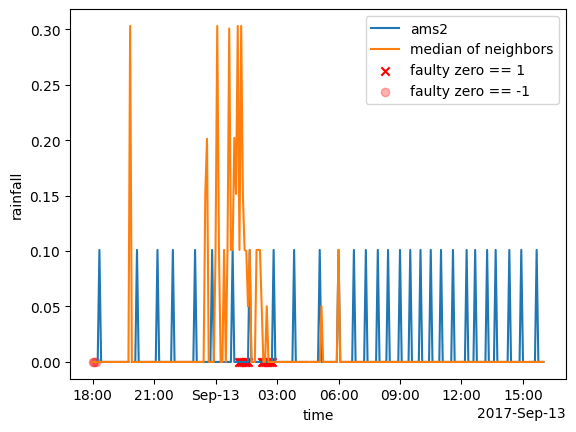

In [12]:
ds_pws.sel(id=pws_id).rainfall.plot(label="ams2")
ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id").plot(label="median of neighbors")
# plt.plot(ds_pws.time, fz_flag * 0.1 - 0.11, 'r', label='faulty zero flag')
plt.scatter(
    ds_pws.time.where(fz_flag == 1),
    fz_flag * 0,
    marker="x",
    c="r",
    label="faulty zero == 1",
)
plt.scatter(
    ds_pws.time.where(fz_flag == -1),
    fz_flag * 0,
    marker="o",
    c="r",
    alpha=0.3,
    label="faulty zero == -1",
)

plt.legend();

Note that the faulty zero filter returns -1 for periods where is cannot be evaluated, e.g. for the first `nint` time steps.